In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import plotly.graph_objects as go
import pandas as pd
import cv2
import matplotlib.image as mpimg
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LayerNormalization, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import LSTM

### Train Data

In [66]:
train_data = []
train_output_arr = []
for coin in ["ada", "btc", "doge", "dot", "eth", "luna", "matic", "shib", "sol", "xrp"]:
    train_data.append(np.memmap(f"image_data/{coin}usdt/training_data.dat", dtype = np.uint8, mode = 'r').reshape((-1, 54, 72)))
    train_data.append(np.memmap(f"image_data/{coin}usdt/validation_data.dat", dtype = np.uint8, mode = 'r').reshape((-1, 54, 72)))
    train_output_arr.append(pd.read_csv(f"image_data/{coin}usdt/training_output.csv"))

train_data = np.concatenate(train_data)
print(train_data.shape)

(280437, 54, 72)


(54, 72)


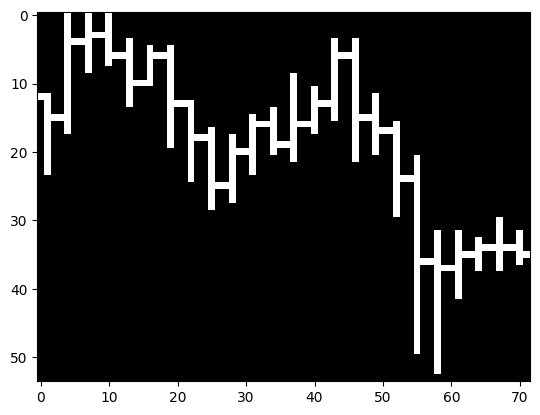

In [67]:
sample = train_data[0]
print(sample.shape)
plt.figure()
plt.imshow(sample, cmap="gray")

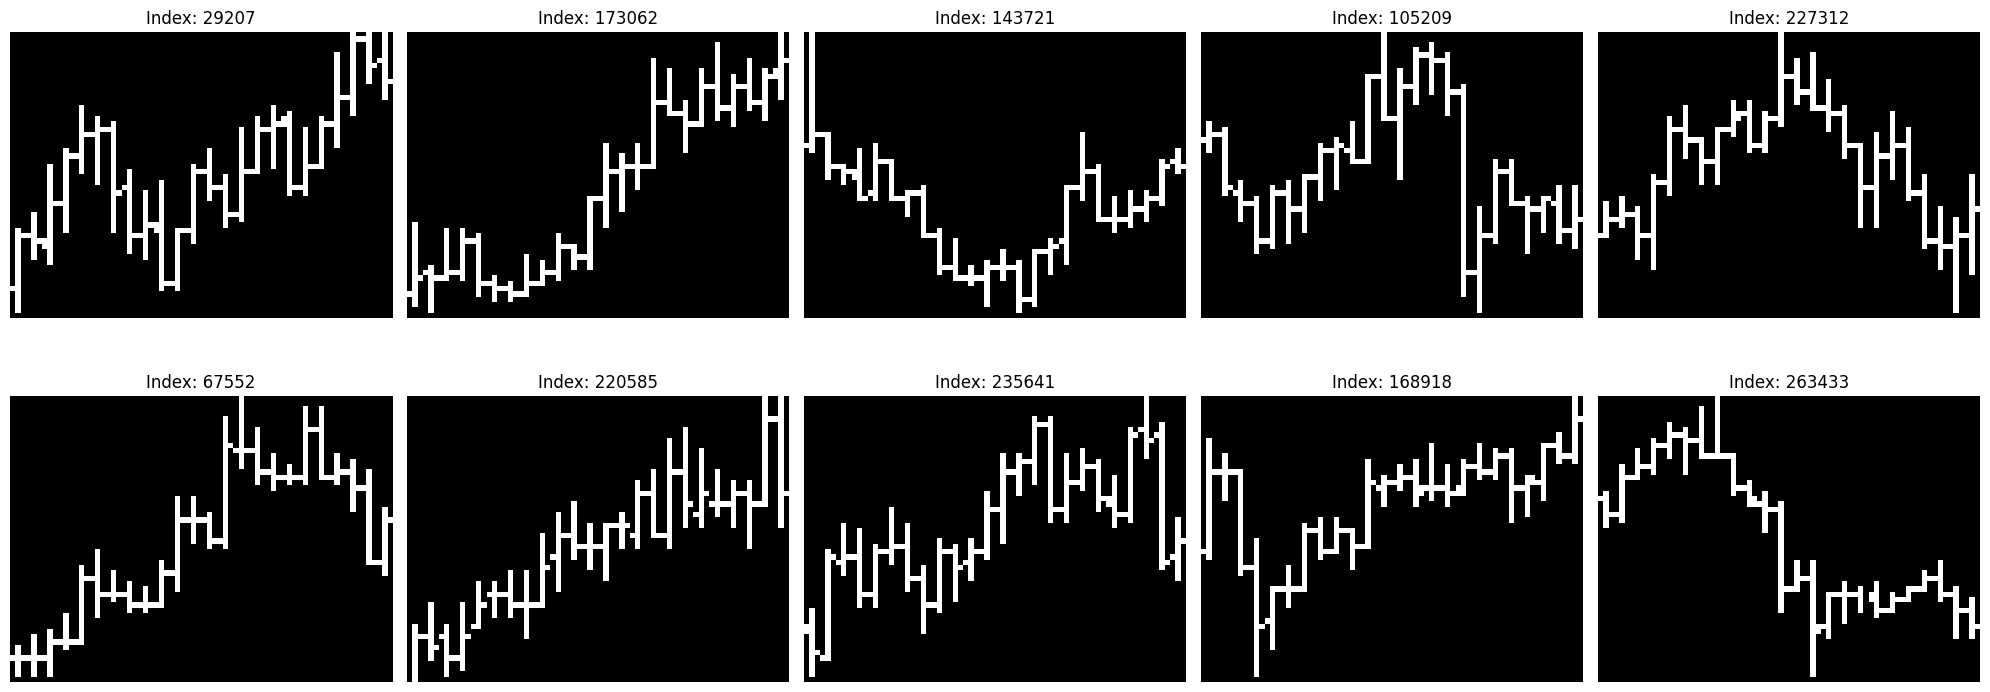

In [68]:
# Plot 10 random images and print their indices
fig, axs = plt.subplots(2, 5, figsize = (20, 8))
for i in range(10):
    index = np.random.randint(0, train_data.shape[0])
    axs[i // 5, i % 5].imshow(train_data[index], cmap = "gray")
    axs[i // 5, i % 5].set_title(f"Index: {index}")
    axs[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()

In [69]:
def normalize(df):
    df["RollingMaxLR"] = df["LogReturns"].rolling(window = 24).apply(lambda x: np.max(x) - np.min(x))
    df["RollingMaxLR"] = df["RollingMaxLR"].fillna(df.loc[23, "RollingMaxLR"])

    df["NormalizedLogReturns"] = df["LogReturns"] / df["RollingMaxLR"]

for i in range(len(train_output_arr)):
    normalize(train_output_arr[i])

In [70]:
train_output = pd.concat(train_output_arr)
train_output

,Open time,LogReturns,RollingMaxLR,NormalizedLogReturns
0,1609545600000,-0.019493,0.094469,-0.206345
1,1609549200000,0.010832,0.094469,0.114658
2,1609552800000,0.004025,0.094469,0.042603
3,1609556400000,0.004180,0.094469,0.044247
4,1609560000000,-0.004065,0.094469,-0.043032
...,...,...,...,...
26235,1704045600000,-0.000966,0.011380,-0.084850
26236,1704049200000,-0.000805,0.011380,-0.070771
26237,1704052800000,-0.003713,0.011380,-0.326283
26238,1704056400000,0.001616,0.011380,0.142011


In [178]:
model = Sequential([
    # Layer 1
    Conv2D(32, kernel_size=(5, 3), padding='same', activation=None, input_shape=(54, 72, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(3, 1)),
    Dropout(0.25),

    # Layer 2
    Conv2D(64, kernel_size=(5, 3), padding='same', activation=None),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(3, 1)),
    Dropout(0.25),

    # Layer 3
    Conv2D(128, kernel_size=(5, 3), padding='same', activation=None),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(3, 1)),
    Dropout(0.25),

    # Fully connected layer
    Flatten(),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/Users/darren/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/darren/anaconda3/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_117 (Conv2D)             │ (None, 54, 72, 32)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 54, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_95 (LeakyReLU)      │ (None, 54, 72, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 18, 72, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 18, 72, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 18, 72, 64)     │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 18, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_96 (LeakyReLU)      │ (None, 18, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_108               │ (None, 6, 72, 64)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 6, 72, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 6, 72, 128)     │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 6, 72, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_97 (LeakyReLU)      │ (None, 6, 72, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_109               │ (None, 2, 72, 128)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 2, 72, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,633 (678.25 KB)

 Trainable params: 173,185 (676.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [179]:
X = train_data.reshape((-1, 54, 72, 1))
y = train_output["NormalizedLogReturns"].values
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(X, y, epochs=1, validation_split=0.2, callbacks=[early_stopping])

model.save("model.h5")
model = tf.keras.models.load_model("model.h5")

6472/6472 ━━━━━━━━━━━━━━━━━━━━ 2414s 373ms/step - loss: 1.8257 - val_loss: 0.0578


In [180]:
# Make predictions
X_train = train_data.reshape((-1, 54, 72, 1))
y_pred = model.predict(X_train).flatten()

# Calculate the loss
loss = np.mean((y_pred - train_output["NormalizedLogReturns"].values) ** 2)
print(f"Loss: {loss}")

# Compare loss against benchmark
benchmark_loss = np.mean((train_output["NormalizedLogReturns"].values) ** 2)
print(f"Benchmark Loss: {benchmark_loss}")

8089/8089 ━━━━━━━━━━━━━━━━━━━━ 620s 77ms/step
Loss: 0.05685174503301579
Benchmark Loss: 0.05628091904922915


### Test Data

In [5]:
test_data = []
test_output_arr = []
for coin in ["ada", "btc", "doge", "dot", "eth", "luna", "matic", "shib", "sol", "xrp"] + ["bonk", "floki", "pepe", "wif"]:
    test_data.append(np.memmap(f"image_data/{coin}usdt/testing_data.dat", dtype = np.uint8, mode = 'r').reshape((-1, 54, 72)))
    test_output_arr.append(pd.read_csv(f"image_data/{coin}usdt/testing_output.csv"))

test_data = np.concatenate(test_data)
print(test_data.shape)

(70297, 54, 72)


In [6]:
for i in range(len(test_output_arr)):
    normalize(test_output_arr[i])

test_output = pd.concat(test_output_arr)
test_output

,Open time,LogReturns,RollingMaxLR,NormalizedLogReturns
0,1712016000000,-0.006622,0.042310,-0.156513
1,1712019600000,0.001943,0.042310,0.045916
2,1712023200000,-0.032046,0.042310,-0.757419
3,1712026800000,-0.005190,0.042310,-0.122678
4,1712030400000,-0.000168,0.042310,-0.003968
...,...,...,...,...
5106,1730397600000,-0.015255,0.043069,-0.354195
5107,1730401200000,-0.016758,0.043069,-0.389091
5108,1730404800000,0.006317,0.041514,0.152169
5109,1730408400000,0.003771,0.041514,0.090842


In [183]:
X_test = test_data.reshape((-1, 54, 72, 1))
y_pred = model.predict(X_test).flatten()

# Calculate the loss
loss = np.mean((y_pred - test_output["NormalizedLogReturns"].values) ** 2)
print(f"Loss: {loss}")

# Compare loss against benchmark
benchmark_loss = np.mean((test_output["NormalizedLogReturns"].values) ** 2)
print(f"Benchmark Loss: {benchmark_loss}")

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 142s 65ms/step
Loss: 0.05811109468581976
Benchmark Loss: 0.05748831188406694
